# Test CLUE performance

In this notebook, we test CLUE's performance for 3 different setups of a Bayesian last-layer MNIST classifier. 

We allow a choice between:
- Classifier dominated backbone 
- Joint training backbone
- Autoencoder dominated backbone

## Setup


In [4]:
inDrive = False

In [5]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/MyImplementation/testing_notebooks')
    import sys

    # Add the parent directory to the system path
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0, parent_dir)

Import libraries

In [6]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler
import models.regene_models


Set the configuration

In [7]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512
    latent_dim = 256

    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'

cfg = Config()

In [8]:
models_dir = '../model_saves/new_regene_models'
results_dir = '../results/new_regene_models'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Backbone
We'll start with the backbone loading. Options are either classifier_dominated, joint_training, or autoencoder_dominated.

In [9]:
classifier_dominated = False
joint_training = True
autoencoder_dominated = True

### Load chosen model

Load model

In [10]:
importlib.reload(models.regene_models)

decoder = models.regene_models.Decoder(latent_dim=cfg.latent_dim, device=cfg.device)
backbone = models.regene_models.Classifier(latent_dim=cfg.latent_dim, num_classes=10, device=cfg.device)

if classifier_dominated:
    backbone.load(models_dir + '/classifier_dominated_classifier_256.pt')
    decoder.load(models_dir + '/classifier_dominated_decoder_256.pt')
    name = 'classifier_dominated'
    bll_name = 'BLL_VI_classifier_dominated_first_256.pt'
elif joint_training:
    backbone.load(os.path.join(models_dir, 'joint_classifier_256.pt'))
    decoder.load(os.path.join(models_dir, 'joint_decoder_256.pt'))
    name = 'joint_training'
    bll_name = 'BLL_VI_joint_training_first_256.pt'
elif autoencoder_dominated:
    backbone.load(models_dir + '/autoencoder_dominated_classifier_full_256.pt')
    decoder.load(models_dir + '/autoencoder_dominated_decoder_256.pt')
    name = 'autoencoder_dominated'
    bll_name = 'BLL_VI_autoencoder_dominated_first_256.pt'

Loaded classifier model from: ../model_saves/new_regene_models/joint_classifier_256.pt
Loaded decoder model from: ../model_saves/new_regene_models/joint_decoder_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/regene_models.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lo

Load the Datasets

In [11]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

## Bayesian Last Layer - VI
Next we'll train a variational inference version of the Bayesian last layer using the chosen backbone.


In [12]:
if inDrive: 
    %pip install torchbnn

### Load the model

In [13]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=cfg.latent_dim,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    device=cfg.device
)

# Verify all model components are on the correct device
print(f"Backbone device: {next(bll_vi.backbone.parameters()).device}")
print(f"Last layer device: {next(bll_vi.last_layer.parameters()).device}")

bll_vi.load_checkpoint(os.path.join(models_dir, bll_name))

Backbone device: mps:0
Last layer device: mps:0
 [load_checkpoint] Loaded checkpoint from ../model_saves/new_regene_models/BLL_VI_joint_training_first_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL_VI.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

### Test the model
To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.


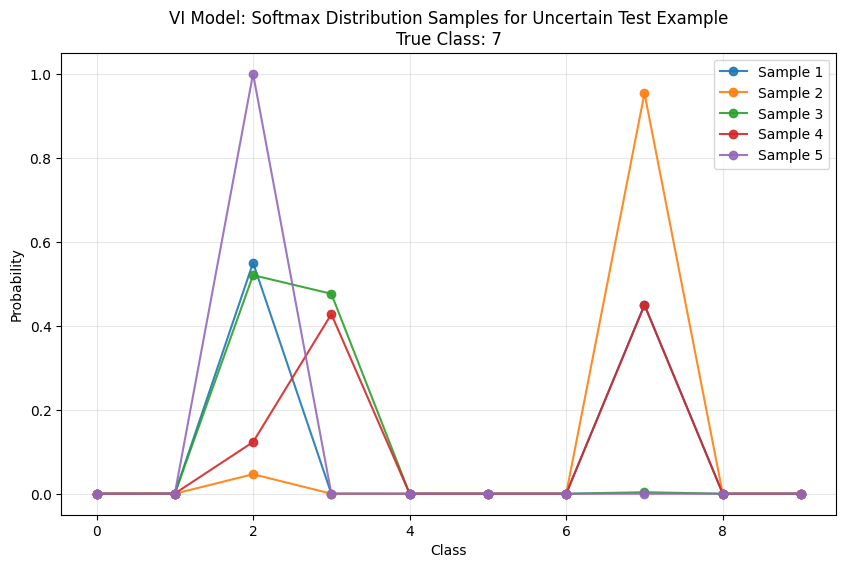

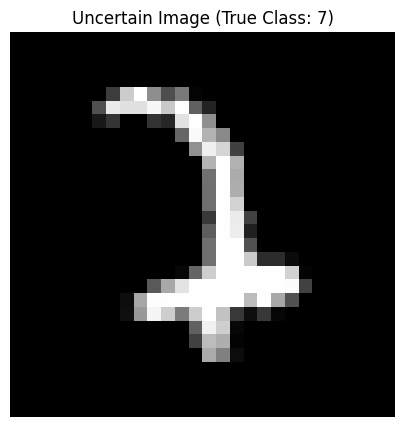

In [14]:
import torch.nn.functional as F

# Search for an uncertain prediction and visualize multiple samples
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]

            # Get multiple predictions for this single example
            outputs = []
            with torch.no_grad():  # Add no_grad context
                for _ in range(num_samples):
                    logits = bll_vi(x_single)
                    probs = F.softmax(logits, dim=1)
                    outputs.append(probs)

            # Stack predictions
            probs = torch.stack(outputs)  # Shape: [num_samples, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [num_samples, num_classes]

            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.7:  # If average confidence is less than 60%
                found_uncertain = True
                break

except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].detach().cpu().numpy(), 'o-', alpha=0.9, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'VI Model: Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()

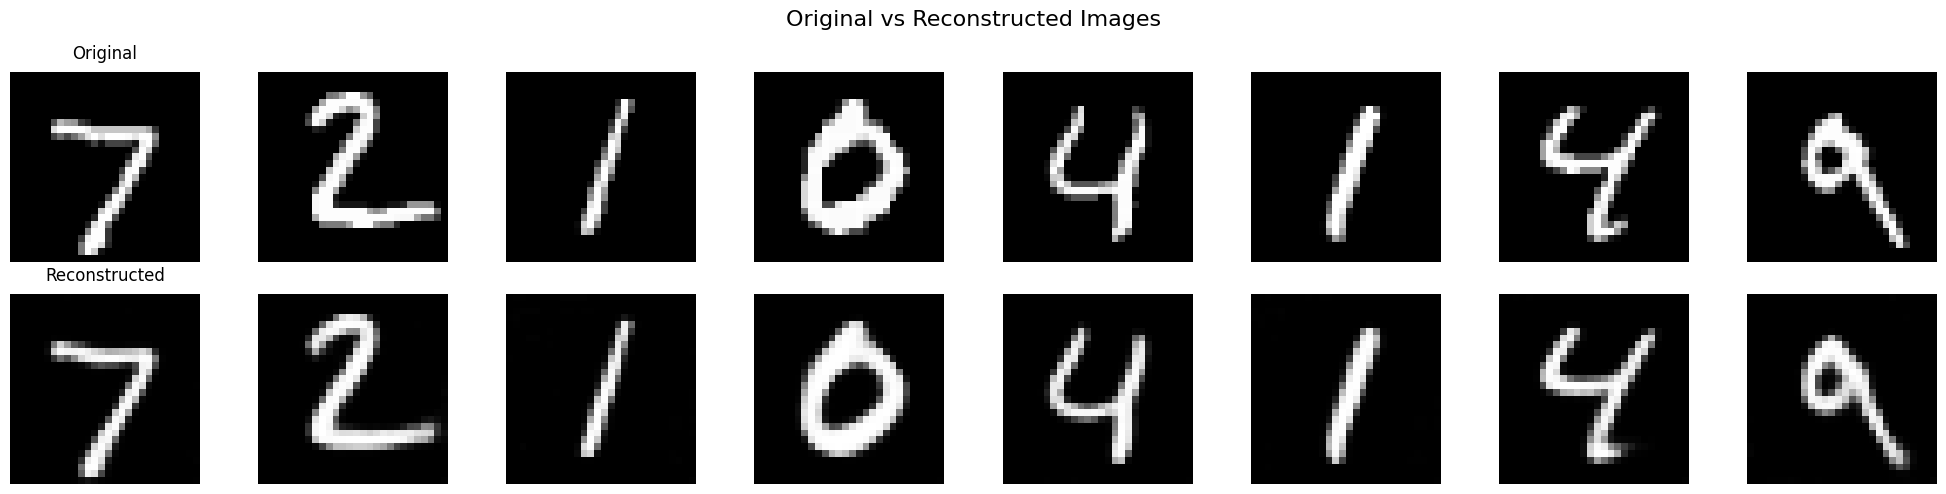

Reconstruction MSE: 0.0035


In [15]:
# Get test images
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(cfg.device)

# Get reconstructions using the classifier and decoder
with torch.no_grad():
    # Get latent representations from classifier
    latent_reps, _ = backbone(test_images)  # Returns (latent_rep, logits)
    # Reconstruct using decoder
    reconstructions = decoder(latent_reps)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions
for i in range(8):
    axes[1,i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()

# Optionally, calculate reconstruction error
mse = nn.MSELoss()
recon_error = mse(reconstructions, test_images)
print(f'Reconstruction MSE: {recon_error.item():.4f}')

## Evaluate CLUE

### Load the VAE

In [16]:
from models.VAE_likelihood import ConvVAELikelihoodEstimator

vae = ConvVAELikelihoodEstimator(latent_dim=20, device=cfg.device)

vae.load_state_dict(torch.load(os.path.join(models_dir, 'vae_likelihood_estimator_20.pt'), map_location=cfg.device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_49999/344240935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(mo

<All keys matched successfully>

### Get Uncertain Images

In [33]:
import importlib
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_clue_counterfactuals, find_uncertain_images, visualize_counterfactual_results, evaluate_single_clue_counterfactual

In [18]:
uncertain_images, uncertain_indices = find_uncertain_images(bll_vi, testloader, n=50, device=cfg.device)

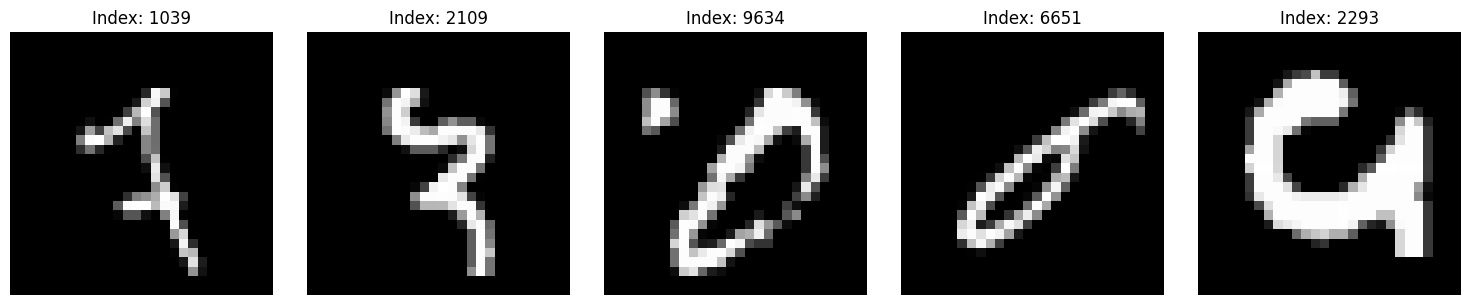

Uncertainty indices of these images: [1039, 2109, 9634, 6651, 2293]


In [19]:
# Plot the first 5 uncertain images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(uncertain_images[i, 0].cpu(), cmap='gray')
    plt.title(f"Index: {uncertain_indices[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Uncertainty indices of these images:", uncertain_indices[:5].tolist())

### Test a single image

Step 00: Loss: 1.2565, Total Entropy: 1.2565, Epistemic Entropy: 0.9545, Aleatoric Entropy: 0.3020, Distance: 0.0000
Step 01: Loss: 1.1100, Total Entropy: 1.1020, Epistemic Entropy: 0.8399, Aleatoric Entropy: 0.2622, Distance: 1.6000
Step 02: Loss: 1.1913, Total Entropy: 1.1788, Epistemic Entropy: 0.9245, Aleatoric Entropy: 0.2542, Distance: 2.5028
Step 03: Loss: 1.1115, Total Entropy: 1.0944, Epistemic Entropy: 0.8021, Aleatoric Entropy: 0.2924, Distance: 3.4217
Step 04: Loss: 0.9991, Total Entropy: 0.9772, Epistemic Entropy: 0.7098, Aleatoric Entropy: 0.2674, Distance: 4.3677
Step 05: Loss: 0.9963, Total Entropy: 0.9701, Epistemic Entropy: 0.6993, Aleatoric Entropy: 0.2708, Distance: 5.2433
Step 06: Loss: 0.9429, Total Entropy: 0.9127, Epistemic Entropy: 0.7010, Aleatoric Entropy: 0.2116, Distance: 6.0517
Step 07: Loss: 0.8619, Total Entropy: 0.8278, Epistemic Entropy: 0.6590, Aleatoric Entropy: 0.1687, Distance: 6.8182
Step 08: Loss: 0.9073, Total Entropy: 0.8697, Epistemic Entropy:

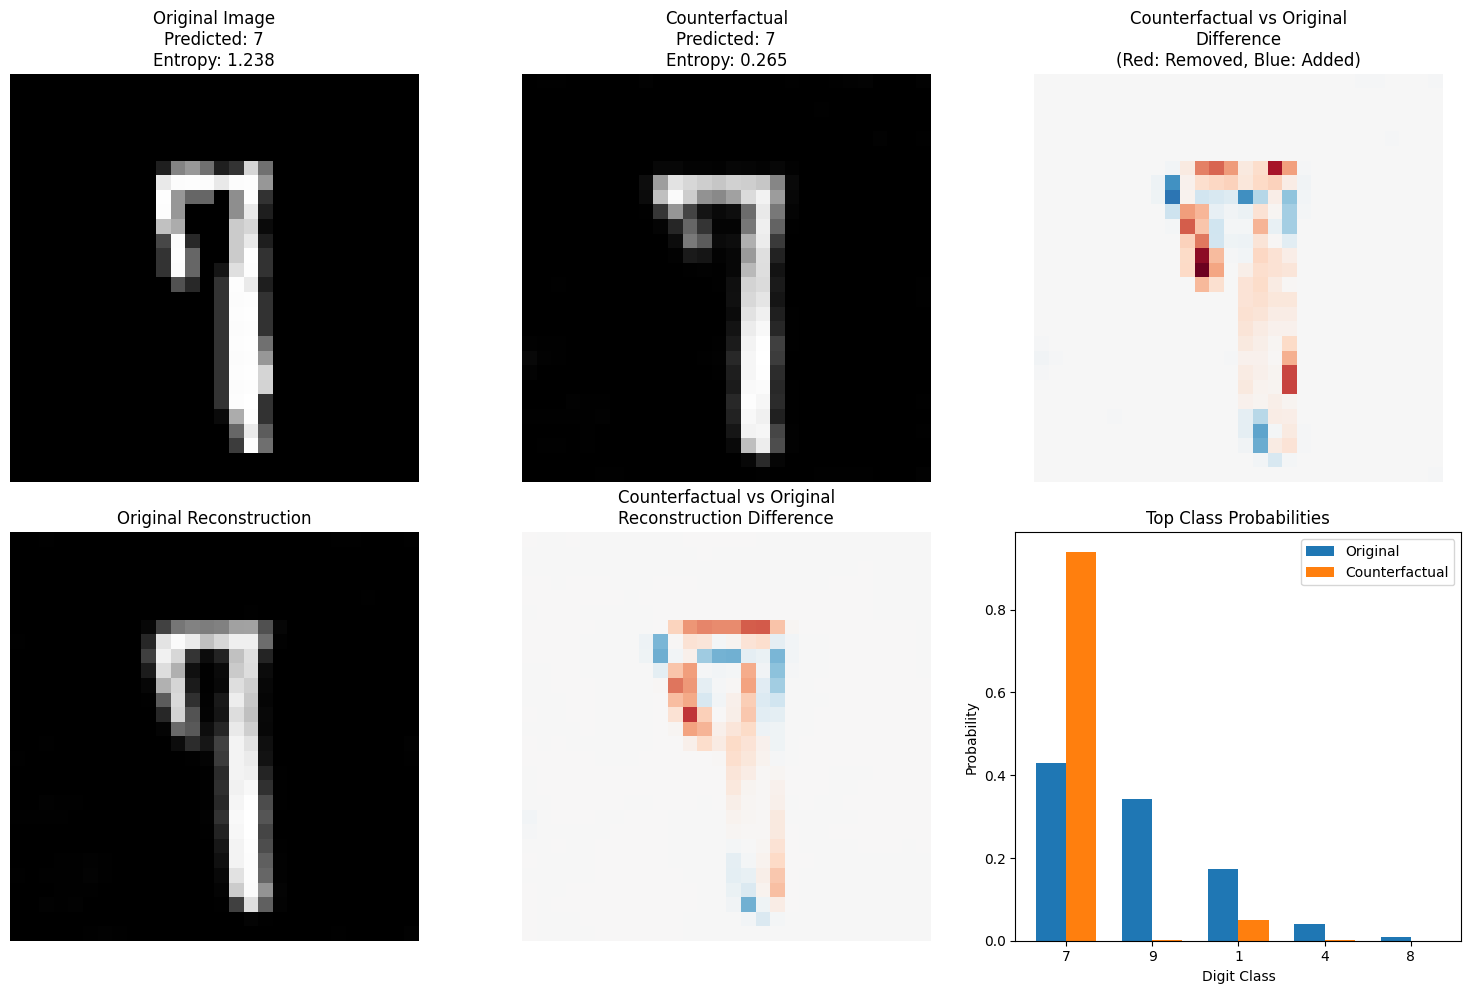


CLUE Counterfactual Results:
Latent Distance: 20.313
Latent Entropy Reduction: 1.202
Reconstruction Entropy Reduction: 0.973

Class probabilities:
Original (Predicted: 7): [0.    0.174 0.002 0.    0.04  0.003 0.    0.429 0.009 0.342]
Counterfactual (Predicted: 7): [0.    0.051 0.001 0.    0.003 0.004 0.    0.94  0.    0.002]

Likelihood metrics:
Original log-likelihood: -74.36
Counterfactual log-likelihood: -81.02
Log-likelihood difference: 6.66
Likelihood ratio: 0.00x more likely
Original realism score: 0.989
Counterfactual realism score: 0.987
Realism score difference: 0.002


In [35]:
results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[49],
    bll_vi,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=100
)

### Get average metrics

In [28]:
results = evaluate_clue_counterfactuals(
    uncertain_images,
    bll_vi,
    decoder,
    vae,
    device=cfg.device,
    steps=100,
    lr=0.01,
    distance_weight=0.05,
)


Aggregate Results over 50 images:
Average latent entropy reduction: 0.384
Average reconstruction entropy reduction: 0.082
Average latent distance: 3.940
Average log likelihood difference: 6.707
Average realism score difference: 0.003


Example 1 (Image Index: 31):
Latent entropy reduction: 1.111
Latent distance: 7.554
Log likelihood difference: -18.628

Example 2 (Image Index: 12):
Latent entropy reduction: 1.005
Latent distance: 7.658
Log likelihood difference: 18.415

Example 3 (Image Index: 20):
Latent entropy reduction: 0.876
Latent distance: 7.248
Log likelihood difference: 18.617

Example 4 (Image Index: 18):
Latent entropy reduction: 0.838
Latent distance: 6.731
Log likelihood difference: -1.269

Example 5 (Image Index: 1):
Latent entropy reduction: 0.811
Latent distance: 6.682
Log likelihood difference: 6.984


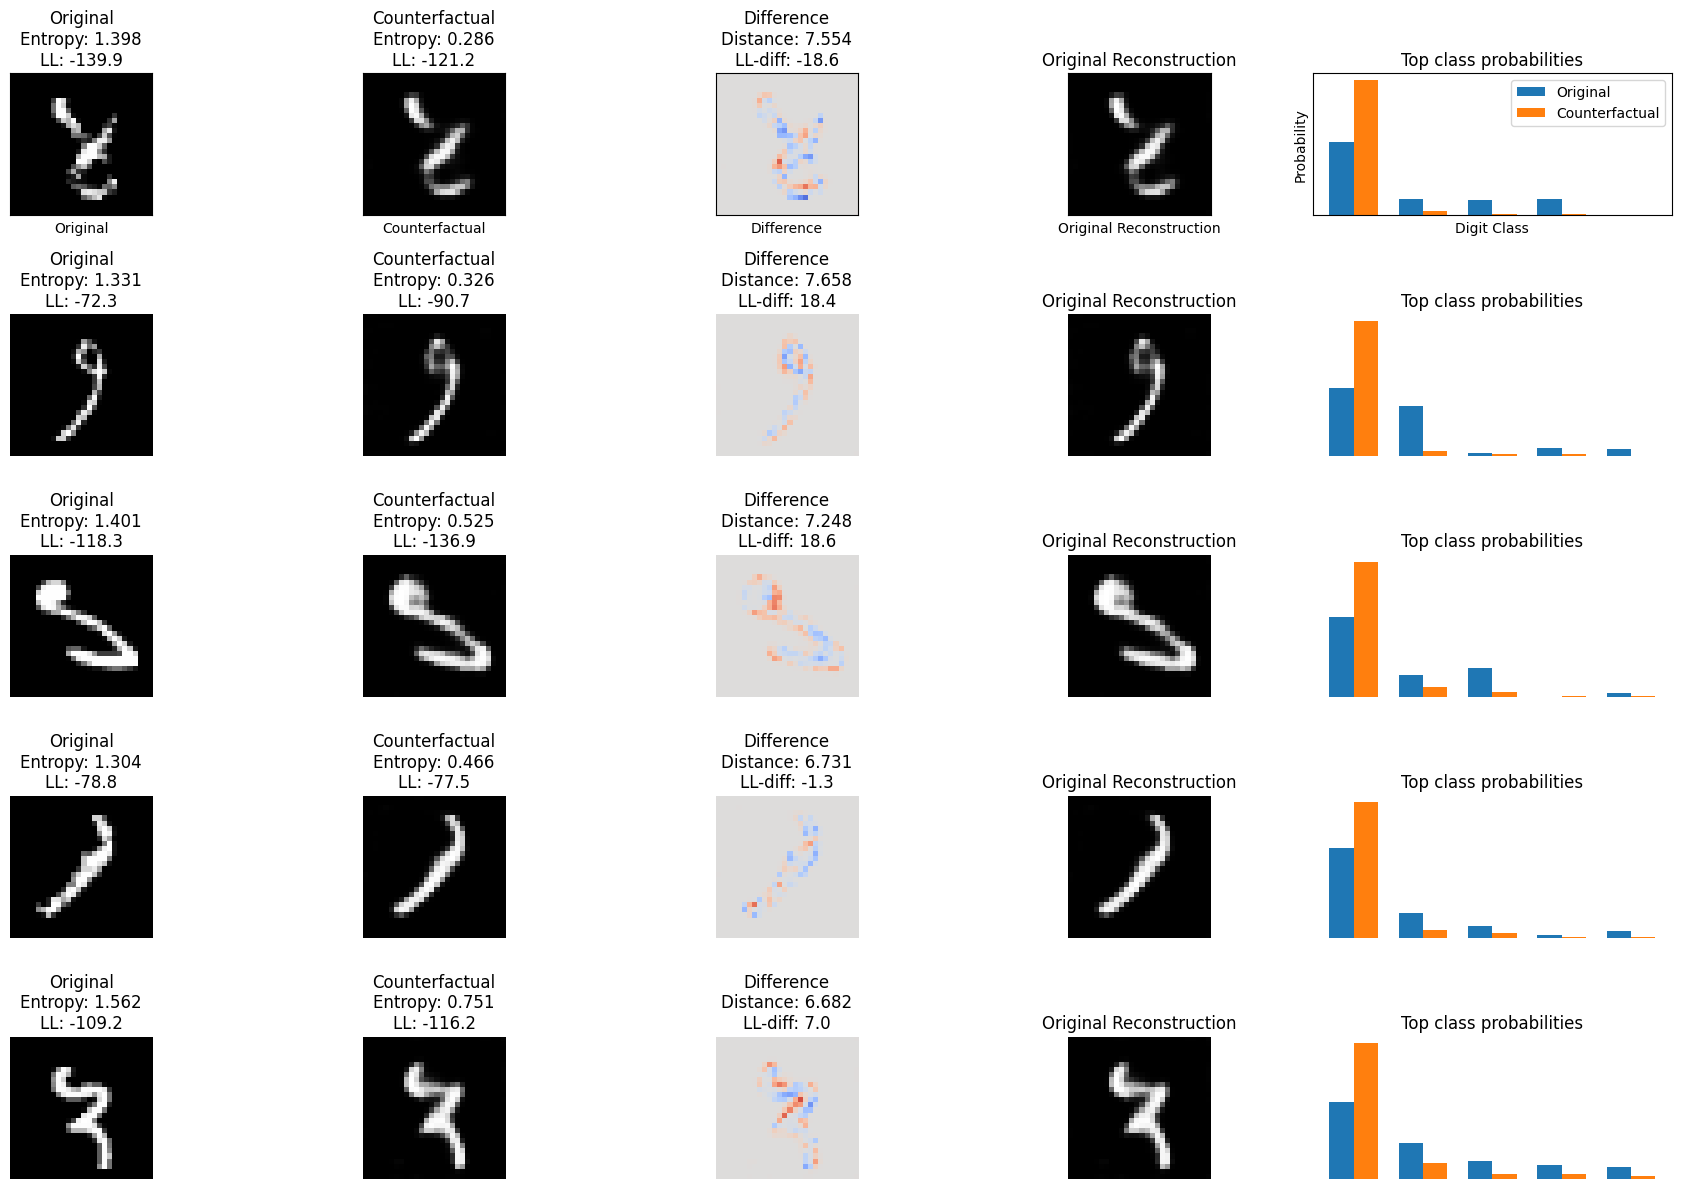

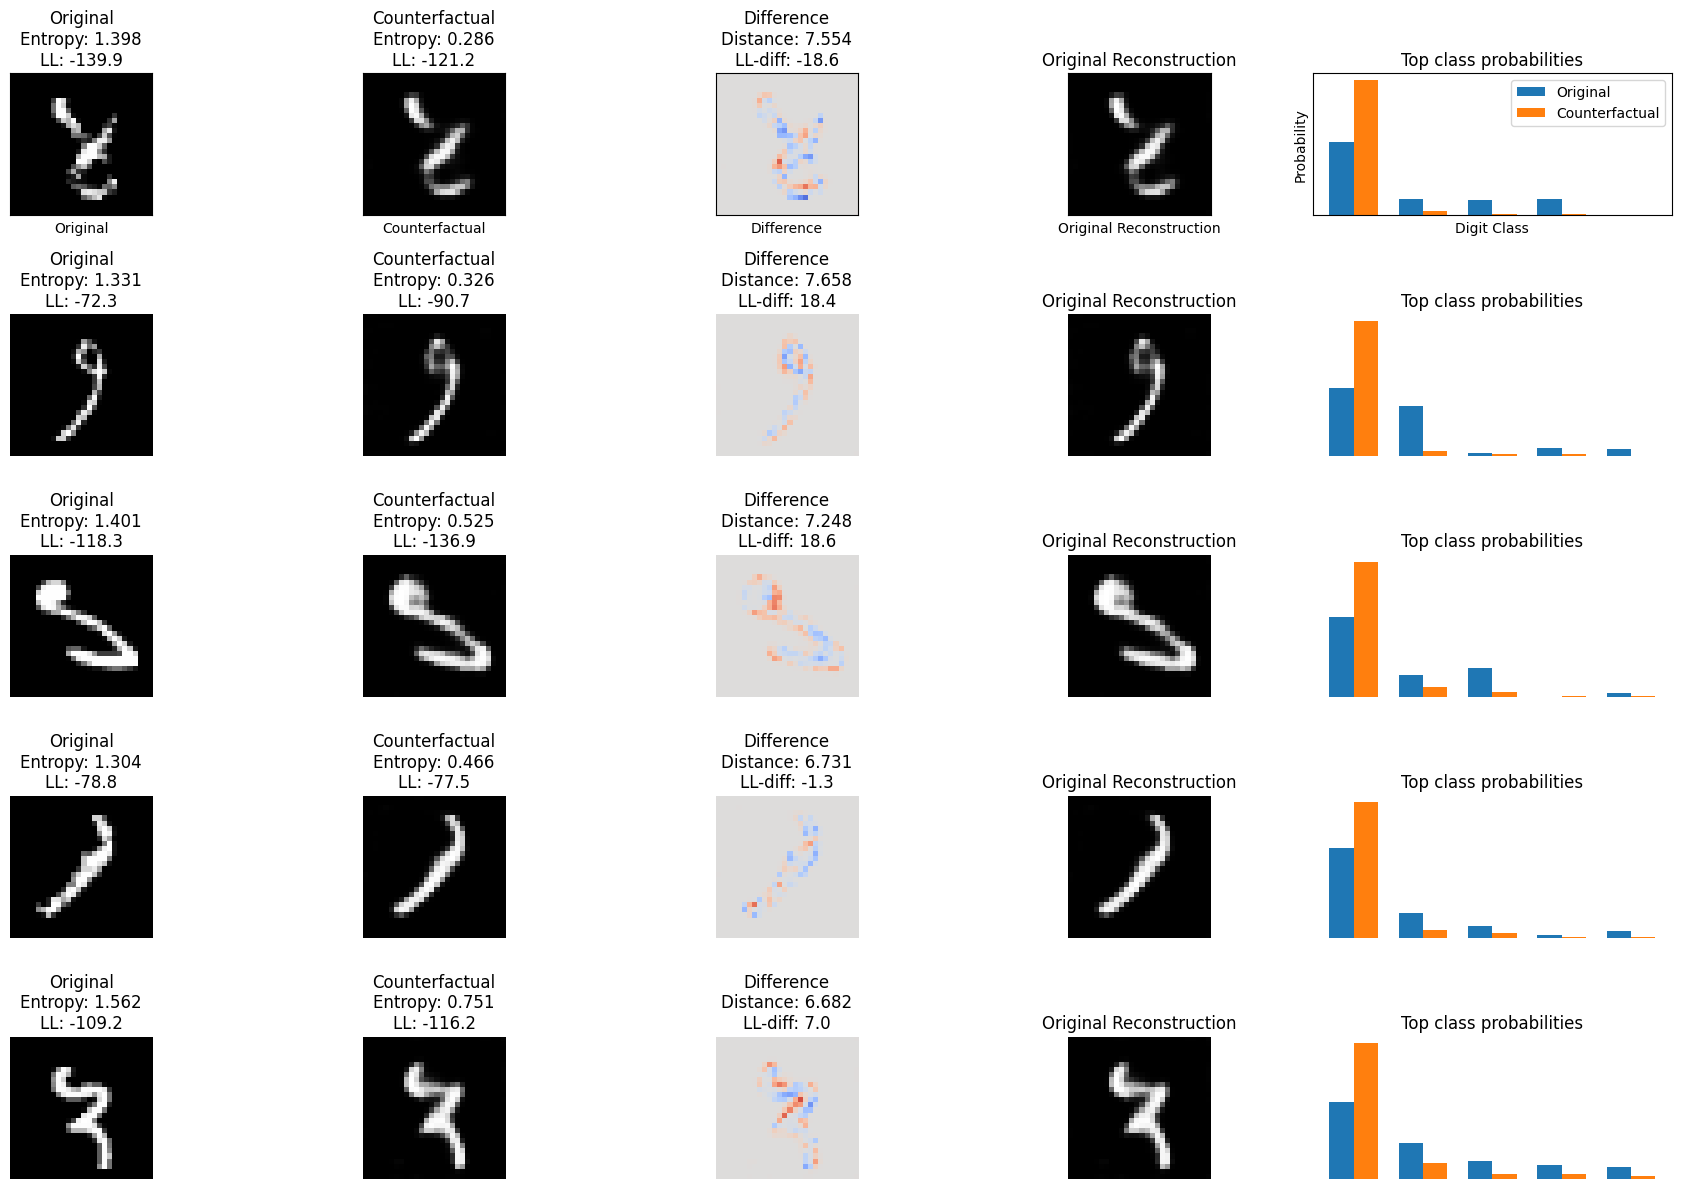

In [34]:
visualize_counterfactual_results(results)